## Importing the Libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.utils import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Embedding, MaxPooling1D, Flatten, Dense, Conv1D, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras.layers import Dropout
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

## Importing variables from the preprocessing notebook as csv files


In [2]:
y = np.loadtxt('y.csv', delimiter=',')
X = pd.read_csv('X.csv')

In [3]:
# Explore the distribution of sequence lengths
sequence_lengths = X['preprocessed_text'].apply(lambda x: len(x.split()))

# Calculate the 95th percentile
percentile_95 = np.percentile(sequence_lengths, 95)

# Set max_length slightly higher than the 95th percentile
max_length = int(percentile_95 * 1.1)

print("Chosen Max Length:", max_length)

Chosen Max Length: 167


In [4]:
# Build a vocabulary from your text data
all_text = ' '.join(X['preprocessed_text'].tolist())
unique_words = set(all_text.split())
vocab_size = len(unique_words) + 1

print("Vocabulary Size:", vocab_size)

Vocabulary Size: 24810


In [5]:
X = X['preprocessed_text']
X = [str(x) for x in X]

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen=max_length)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Hyper parameter Tuning

In [6]:
# Define a function to create the CNN model
def create_model(embedding_dim=50, filters=100, kernel_size=3, pool_size=2, dense_units=64, dropout_rate=0.0):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))  # Corrected parameter name
    model.add(Dropout(rate=dropout_rate))  # Corrected parameter name
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the grid of hyperparameter values to search
param_grid = {
    'embedding_dim': [50, 60],
    'filters': [64, 70],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],
    'dense_units': [64, 70],
    'dropout_rate': [0.2, 0.5]
}

# Create a KerasClassifier based on the function
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14340\3877916236.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


In [7]:
# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy
print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_}')

75/75 [==============================] - 1s 11ms/step
Best Parameters: {'dense_units': 70, 'dropout_rate': 0.5, 'embedding_dim': 60, 'filters': 70, 'kernel_size': 3, 'pool_size': 3}
Best Accuracy: 0.9291504758140131


## CNN Model

In [6]:
# Create a Sequential model
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=60, input_length=max_length))

# Add Convolutional layers
model.add(Conv1D(filters=70, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))

# Flatten layer
model.add(Flatten())

# Add Fully Connected layers
model.add(Dense(70, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [7]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 167, 60)           1488600   
                                                                 
 conv1d (Conv1D)             (None, 165, 70)           12670     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 55, 70)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3850)              0         
                                                                 
 dense (Dense)               (None, 70)                269570    
                                                                 
 module_wrapper (ModuleWrapp  (None, 70)               0         
 er)                                                    

In [9]:
# Train the model and store the history
history_cnn = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
179/179 [==============================] - 7s 35ms/step - loss: 0.4107 - accuracy: 0.8169 - val_loss: 0.1813 - val_accuracy: 0.9272
Epoch 2/10
179/179 [==============================] - 4s 24ms/step - loss: 0.1169 - accuracy: 0.9597 - val_loss: 0.1591 - val_accuracy: 0.9349
Epoch 3/10
179/179 [==============================] - 5s 27ms/step - loss: 0.0351 - accuracy: 0.9914 - val_loss: 0.1951 - val_accuracy: 0.9300
Epoch 4/10
179/179 [==============================] - 5s 30ms/step - loss: 0.0121 - accuracy: 0.9982 - val_loss: 0.2613 - val_accuracy: 0.9265
Epoch 5/10
179/179 [==============================] - 5s 26ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.3023 - val_accuracy: 0.9265
Epoch 6/10
179/179 [==============================] - 5s 26ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.3232 - val_accuracy: 0.9286
Epoch 7/10
179/179 [==============================] - 5s 30ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.3562 - val_accuracy: 0.9307

## Model Evaluation on Training and Validation Data

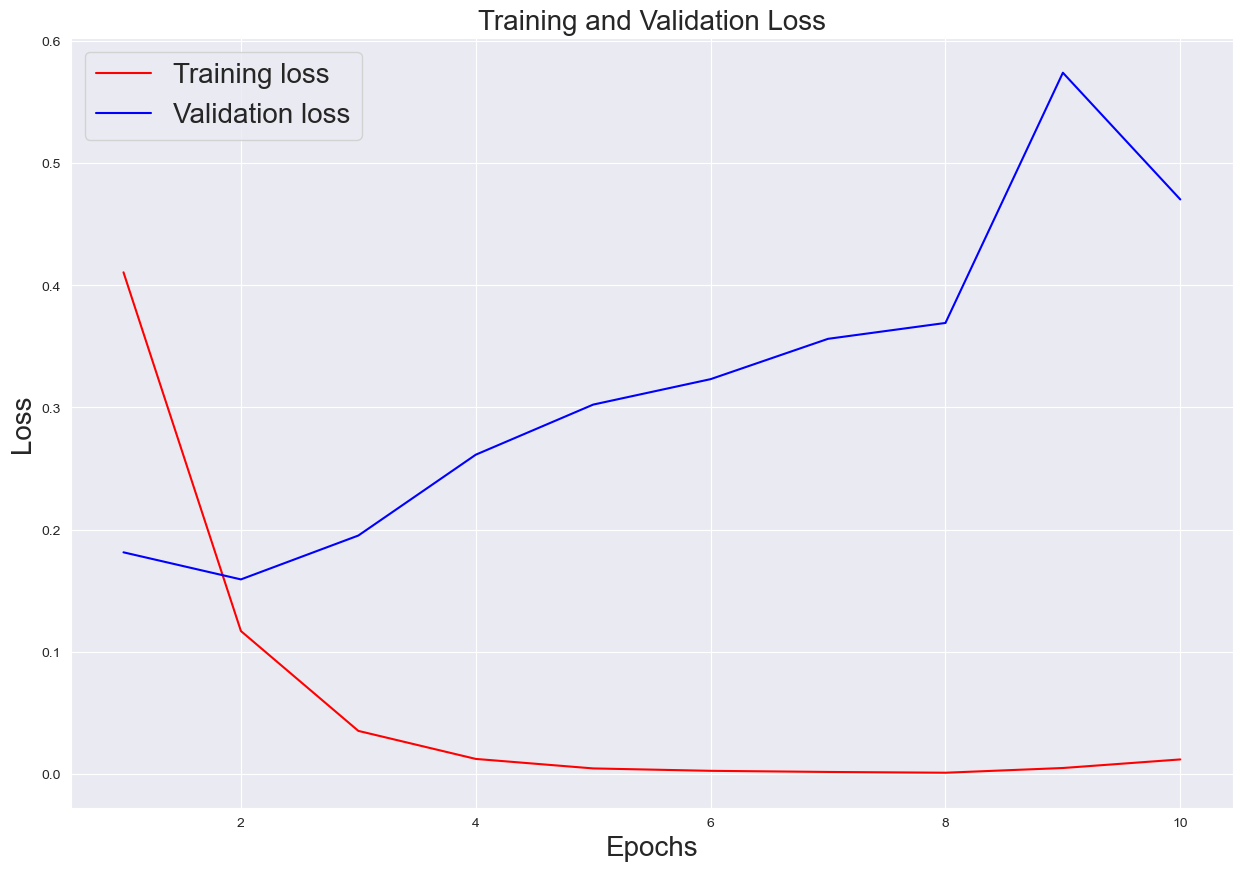

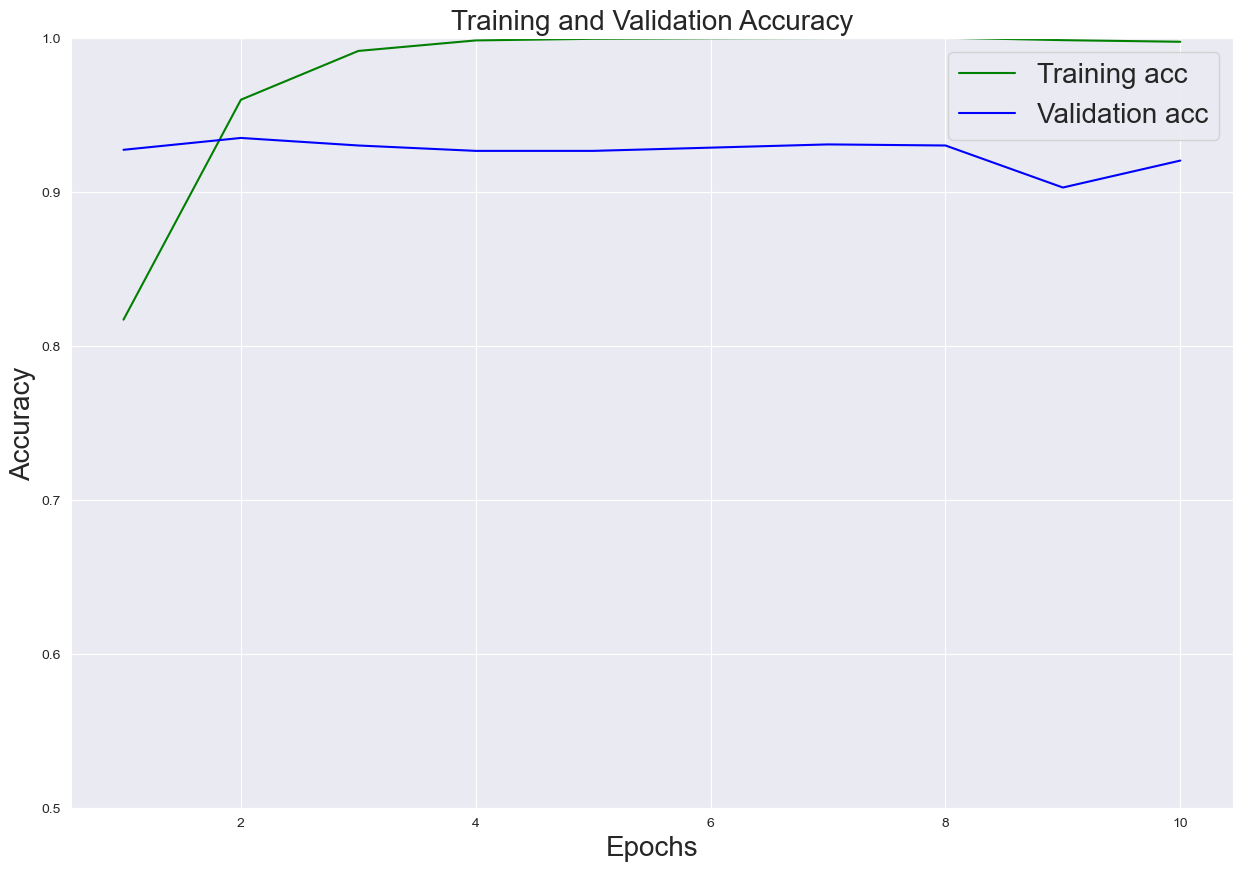

In [10]:
# Extract training history
history_cnn_dict = history_cnn.history

# Extract metrics
acc_cnn = history_cnn_dict['accuracy']
val_acc_cnn = history_cnn_dict['val_accuracy']
loss_cnn = history_cnn_dict['loss']
val_loss_cnn = history_cnn_dict['val_loss']
epochs_cnn = range(1, len(acc_cnn) + 1)

# Plot training and validation loss
plt.figure(figsize=(15, 10))
plt.plot(epochs_cnn, loss_cnn, 'r', label='Training loss')
plt.plot(epochs_cnn, val_loss_cnn, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(15, 10))
plt.plot(epochs_cnn, acc_cnn, 'g', label='Training acc')
plt.plot(epochs_cnn, val_acc_cnn, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Model Evaluation on Test Data

In [11]:
# Evaluate the model on the test data
evaluation = model.evaluate(X_test, y_test)

# Extract the evaluation metrics
loss, accuracy = evaluation

56/56 [==============================] - 1s 11ms/step - loss: 0.5590 - accuracy: 0.9183


In [12]:
# Get model predictions on the test data
y_pred_probs  = model.predict(X_test)

# Apply a threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

56/56 [==============================] - 1s 12ms/step
Loss: 0.5590168833732605
Accuracy: 0.9182530641555786
Precision: 0.9347181008902077
Recall: 0.9559939301972686
F1-Score: 0.9452363090772693


## Classification Report

In [13]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       468
         1.0       0.93      0.96      0.95      1318

    accuracy                           0.92      1786
   macro avg       0.90      0.88      0.89      1786
weighted avg       0.92      0.92      0.92      1786



## Confusion Matrix

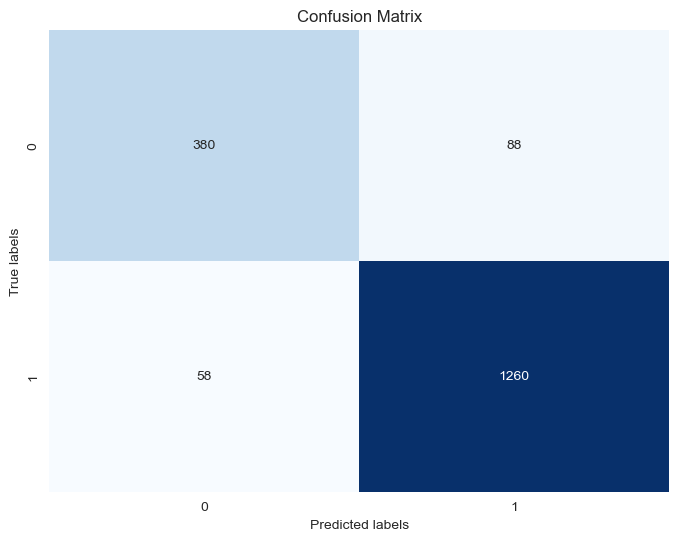

In [14]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
conf_matrix

array([[ 380,   88],
       [  58, 1260]], dtype=int64)

## ROC Curve and AUC

In [16]:
# Compute the false positive rate (FPR) and true positive rate (TPR) for different threshold values
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

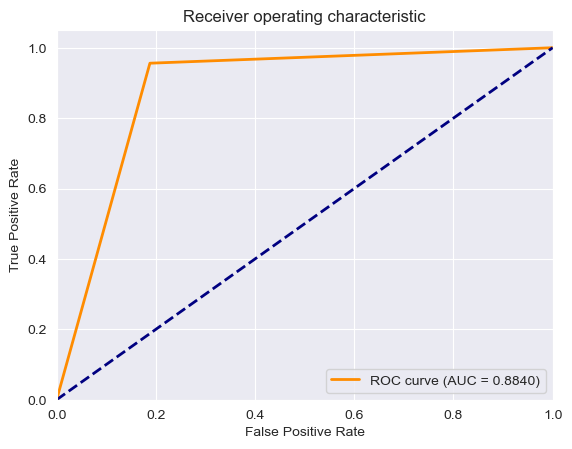

In [17]:
# Plotting the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)'
                                                   % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Calculating the AUC
roc_auc = auc(fpr, tpr)
print("AUC: %0.4f"%roc_auc)

AUC: 0.8840
